# Cloud Optimized Geotiff (COG) Overview Resampling

When making cloud optimized geotiffs (COGs) you can select the resampling method used to generate the overviews. Different types of data can drastically change appearance when more zoomed out based on the method selected. This is most important when using software that renders from overviews (e.g QGIS, ArcGIS), particularly web tilers like Titiler. Also when using a tiling service on high resolution data you will often have many tiles of source data. The idea behind this notebook, is that before you generate all your final output data, as COGs, or if you need to rebuild your overviews you should first test on some representative samples. After testing you'll then know which method to use in your data pipeline.

This notebook loops over the overview resampling methods available in gdal applying it to the same sample tile so that we can compare how the dataset will appear when zoomed out from the full resolution. 

> Note: GDAL 3.2 added the ability to specify the resampling method for the overviews specifically. GDAL 3.3 added a couple of new resampling methods. 

## Setup Environment

* Requires gdal >= 3.2 for Overview Resampling to work
* RMS resampling was added in GDAL 3.3
* TODO: investigate doing in memory with rio-cogeo

```
mamba create -q -y -n gdal35 -c conda-forge 'gdal>=3.3' 'rasterio=1.3.3' 'rio-cogeo=3.5.0' ipykernel boto3 matplotlib
```

Remember to switch your notebook kernel if you made a new env, you may need to activate the new env first.

## Setup the code

In [1]:
# Verify the GDAL version
!gdalinfo --version

GDAL 3.5.3, released 2022/10/21


In [2]:
import boto3
import subprocess
import os

import matplotlib.pyplot as plt

import rasterio as rio
from rasterio.session import AWSSession
from rasterio.plot import show
from rio_cogeo import cog_translate, cog_profiles


In [3]:
# For this example copy the tif to the same location as the expected output
tile = '/projects/local_data/boreal_agb_202206061654544252_0076s.tif'


In [4]:
# The original file does not contain overviews
#!gdalinfo {tile}
!rio cogeo info {tile}

Driver: GTiff
File: /projects/local_data/boreal_agb_202206061654544252_0076s.tif
COG: False
Compression: None
ColorSpace: None

Profile
    Width:            3000
    Height:           3000
    Bands:            2
    Tiled:            False
    Dtype:            float32
    NoData:           nan
    Alpha Band:       False
    Internal Mask:    False
    Interleave:       PIXEL
    ColorMap:         False
    ColorInterp:      ('gray', 'undefined')
    Scales:           (1.0, 1.0)
    Offsets:          (0.0, 0.0)

Geo
    Crs:              PROJCS["unknown",GEOGCS["unknown",DATUM["Unknown_based_on_GRS80_ellipsoid",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],TOWGS84[0,0,0,0,0,0,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",40],PARAMETER["longitude_of_center",180],PARAMETER["standard_parallel_1",50],PARAMETER["standard_parallel_2",70],PARAMETER["false_ea

## Generate Overviews

Now lets generate overviews with each of the resampling methods possible in GDAL.

In [5]:
def generate_overview(src_path: str, out_dir: str, resample_method: str) -> str:
    ''' 
    Create a copy of original GeoTiff as COG with different overview resampling method
    src_path = the original GeotTiff
    out_dir = the folder for outputs (can differ from src)
    method = the resampling method
    return = the path to the new file
    '''
    #make sure the output folder exists
    os.makedirs(out_dir, exist_ok=True)
    dst_path = src_path.replace(".tif", f"_{resample_method}.tif")
    dst_path = f"{out_dir}/{os.path.basename(dst_path)}"
    
    config = {"GDAL_NUM_THREADS": "ALL_CPUS", "GDAL_TIFF_OVR_BLOCKSIZE": "512"} 
    output_profile = cog_profiles.get("deflate")
    output_profile.update({"blockxsize": "512", "blockysize": "512"})
    
    print(f"Creating COG using '{resample_method}' method: {dst_path}")
    cog_translate(
        src_path,
        dst_path,
        output_profile,
        config=config,
        overview_resampling=resample_method,
        forward_band_tags=True,
        use_cog_driver=True,
        quiet=True,
    )

    return dst_path

In [6]:
# This is a list of resampling methods that GDAL 3.4+ allows
#resample_methods = ["AVERAGE", "NEAREST", "BILINEAR", "CUBIC", "CUBICSPLINE", "LANCZOS", "MODE", "RMS"]

from rasterio.enums import Resampling as ResamplingEnums

# Drop some irrelevant methods
OverviewResampling = [r for r in ResamplingEnums if (r.value < 8) or r.value > 13]
resample_methods = [r.name for r in OverviewResampling]
print(resample_methods)

['nearest', 'bilinear', 'cubic', 'cubic_spline', 'lanczos', 'average', 'mode', 'gauss', 'rms']


In [7]:
# For each resampling method create a copy of the data creating overviews with the method.
out_dir = '/projects/local_data'
files = [generate_overview(tile, out_dir, resample_method) for resample_method in resample_methods] 


Creating COG using 'nearest' method: /projects/local_data/boreal_agb_202206061654544252_0076s_nearest.tif
Creating COG using 'bilinear' method: /projects/local_data/boreal_agb_202206061654544252_0076s_bilinear.tif
Creating COG using 'cubic' method: /projects/local_data/boreal_agb_202206061654544252_0076s_cubic.tif
Creating COG using 'cubic_spline' method: /projects/local_data/boreal_agb_202206061654544252_0076s_cubic_spline.tif
Creating COG using 'lanczos' method: /projects/local_data/boreal_agb_202206061654544252_0076s_lanczos.tif
Creating COG using 'average' method: /projects/local_data/boreal_agb_202206061654544252_0076s_average.tif
Creating COG using 'mode' method: /projects/local_data/boreal_agb_202206061654544252_0076s_mode.tif
Creating COG using 'gauss' method: /projects/local_data/boreal_agb_202206061654544252_0076s_gauss.tif
Creating COG using 'rms' method: /projects/local_data/boreal_agb_202206061654544252_0076s_rms.tif


In [8]:
files

['/projects/local_data/boreal_agb_202206061654544252_0076s_nearest.tif',
 '/projects/local_data/boreal_agb_202206061654544252_0076s_bilinear.tif',
 '/projects/local_data/boreal_agb_202206061654544252_0076s_cubic.tif',
 '/projects/local_data/boreal_agb_202206061654544252_0076s_cubic_spline.tif',
 '/projects/local_data/boreal_agb_202206061654544252_0076s_lanczos.tif',
 '/projects/local_data/boreal_agb_202206061654544252_0076s_average.tif',
 '/projects/local_data/boreal_agb_202206061654544252_0076s_mode.tif',
 '/projects/local_data/boreal_agb_202206061654544252_0076s_gauss.tif',
 '/projects/local_data/boreal_agb_202206061654544252_0076s_rms.tif']

In [9]:
# Check that the overviews were created
#!gdalinfo {files[0]} | grep Overviews
!rio cogeo info {files[0]}

Driver: GTiff
File: /projects/local_data/boreal_agb_202206061654544252_0076s_nearest.tif
COG: True
Compression: DEFLATE
ColorSpace: None

Profile
    Width:            3000
    Height:           3000
    Bands:            2
    Tiled:            True
    Dtype:            float32
    NoData:           nan
    Alpha Band:       False
    Internal Mask:    False
    Interleave:       PIXEL
    ColorMap:         False
    ColorInterp:      ('gray', 'undefined')
    Scales:           (1.0, 1.0)
    Offsets:          (0.0, 0.0)

Geo
    Crs:              PROJCS["unknown",GEOGCS["unknown",DATUM["Unknown_based_on_GRS80_ellipsoid",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],TOWGS84[0,0,0,0,0,0,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",40],PARAMETER["longitude_of_center",180],PARAMETER["standard_parallel_1",50],PARAMETER["standard_parallel_2",70],PARAMETER[

## Compare the Results

Now that we've generated each of the overview methods we can plot the full data and each overview. The overviews are labelled by their magnification. Example and overview of 2, is the dimensions divided by 2. Typically in COGs you will keep making overviews until the one of the dimensions is less than 512 pixels.

In [10]:
def compare_overviews(image: str, fig, ax_list, row):
    '''
    Read the original data, and overviews an plot them.
    TODO: limit the size of data read
    image = the path to input COG to read
    '''
    aws_session = AWSSession(boto3.Session())
    with rio.Env(aws_session):
        with rio.open(image, 'r') as src:
            #Plot the 1st band
            oviews = src.overviews(1)
            #fig, ax_list = plt.subplots(ncols=(len(oviews)+1), nrows=1, figsize=(16,4))
            show(src, ax=ax_list[row, 0])
            
            bname = os.path.basename(image)
            row_name = bname.split("_")[-1].replace('.tif', '')
            
            ax_list[row,0].set_title("Full Resolution")
            ax_list[row,0].set_ylabel(row_name)
            ax_list[row,0].xaxis.set_ticklabels([])
            ax_list[row,0].yaxis.set_ticklabels([])
            
            #increment counter so overviews plot starting in the second column
            k = 1
            for oview in oviews:
                height = int(src.height // oview)
                width = int(src.width // oview)
                thumbnail = src.read(1, out_shape=(1, height, width))
                show(thumbnail, ax=ax_list[row,k])
                ax_list[row,k].set_title(f'{height}x{width}')
                ax_list[row,k].xaxis.set_ticklabels([])
                ax_list[row,k].yaxis.set_ticklabels([])
                k += 1

    return


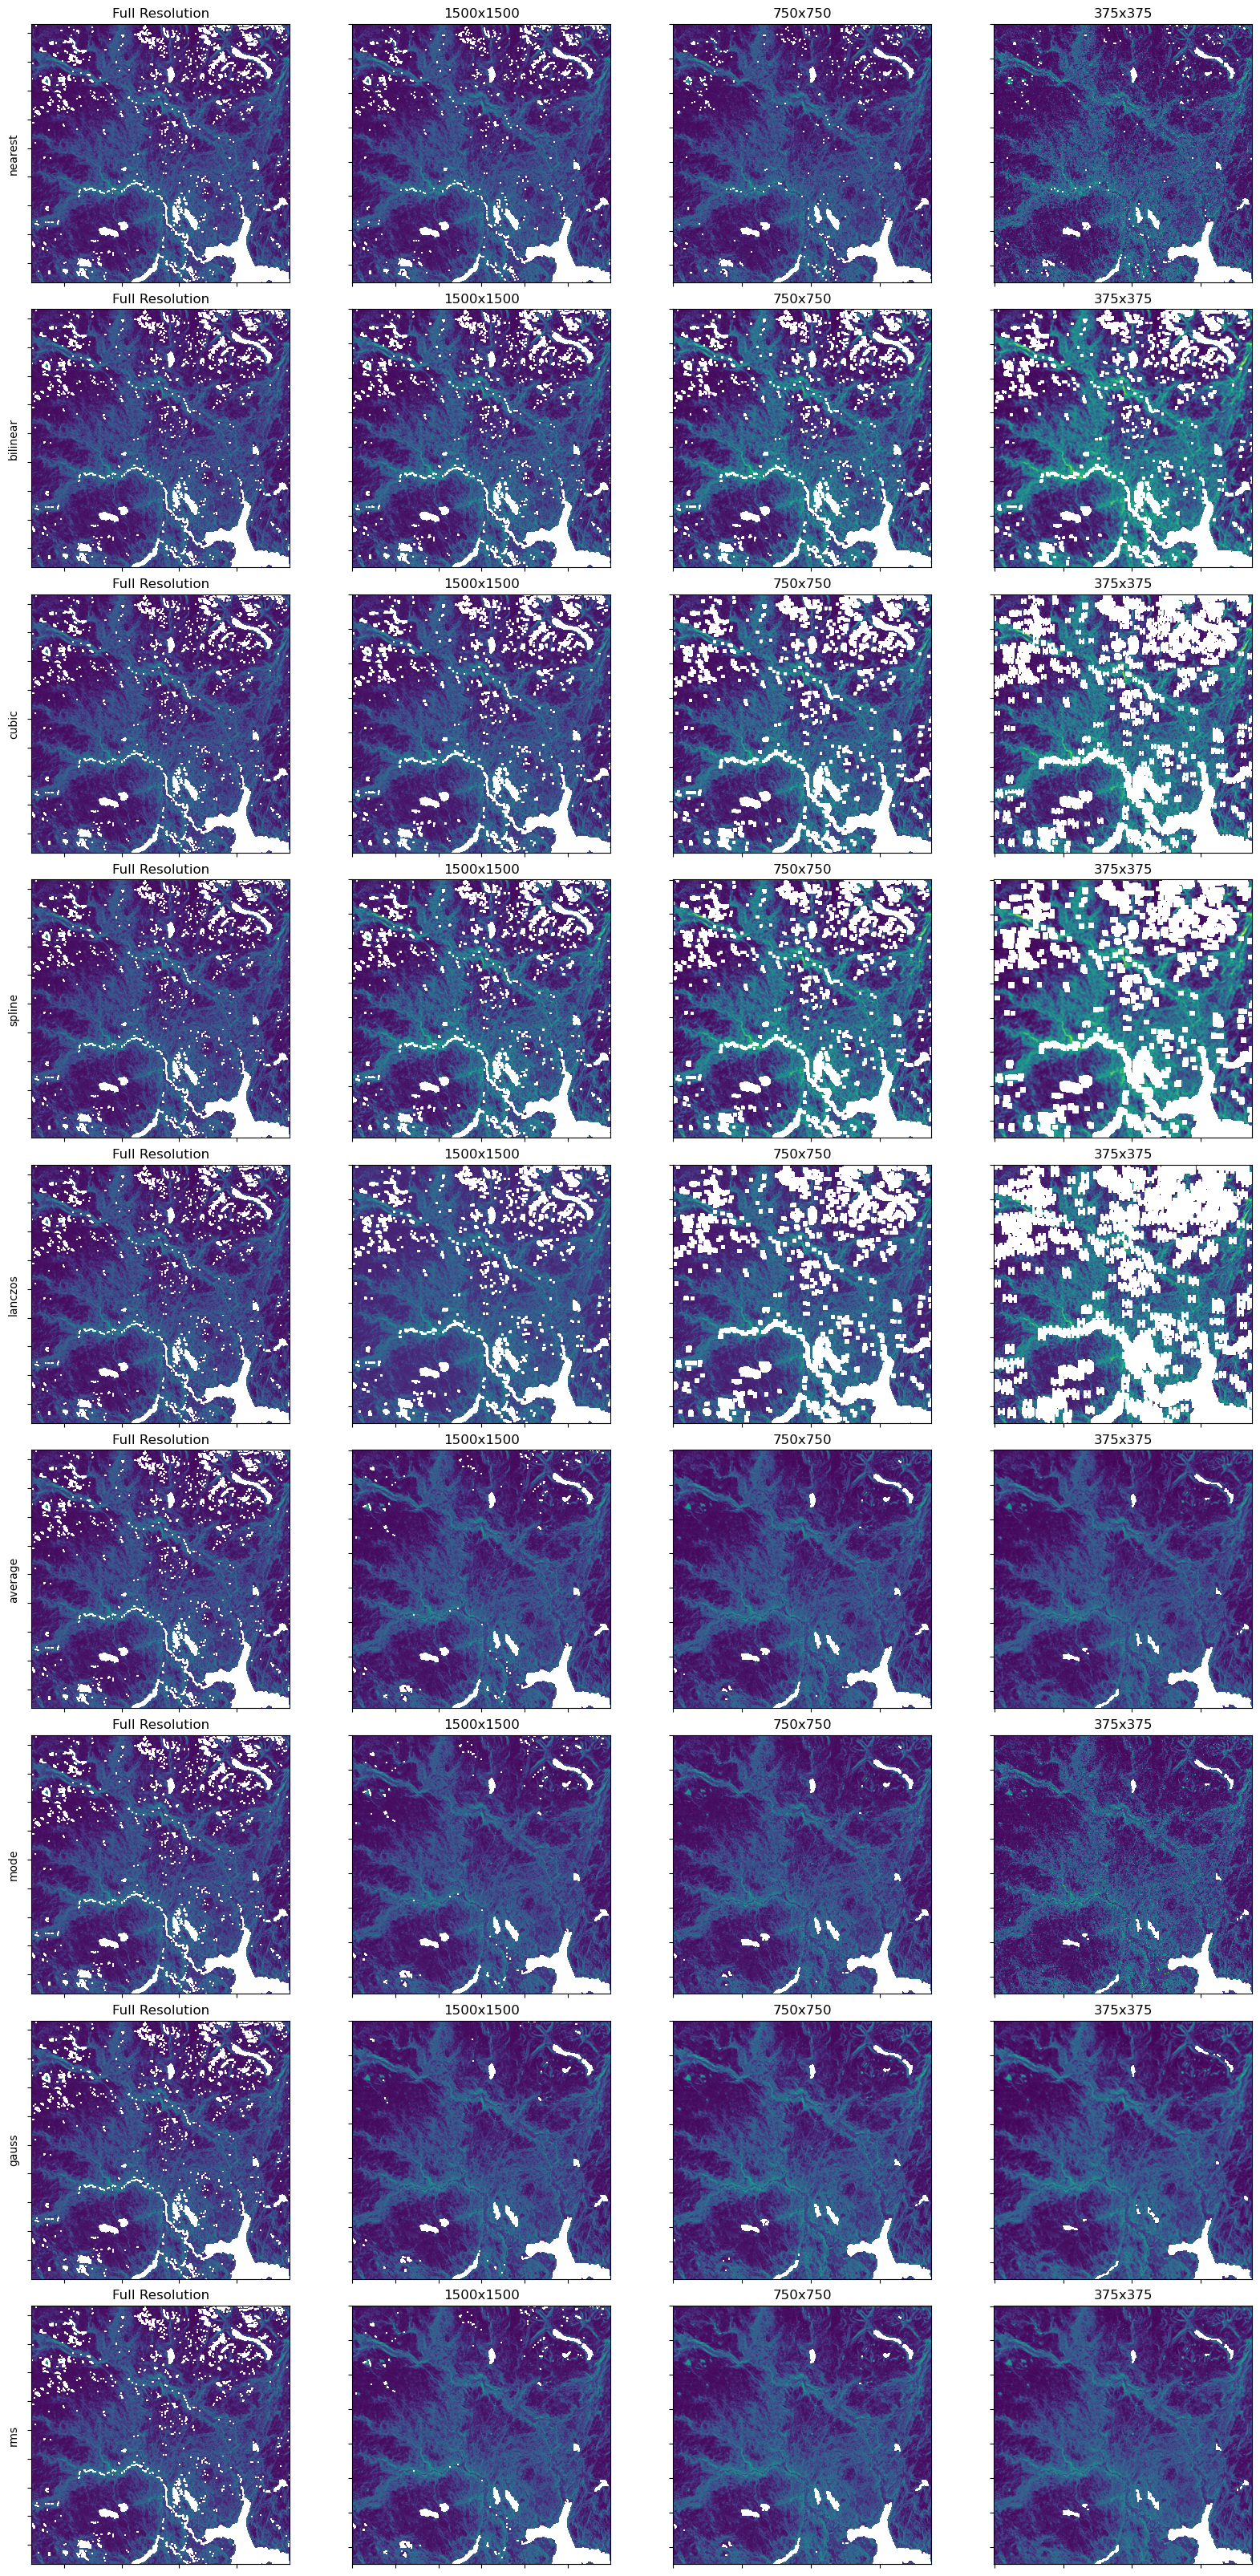

In [11]:
# plot all the variants
# interpretation details below the plot
# hard coding levels for now
fig, ax_list = plt.subplots(ncols=4, nrows=len(files), figsize=(16,32), constrained_layout=True)
row = 0
for file in files:
    compare_overviews(file, fig, ax_list, row)
    row += 1
                    
#catch = [compare_overviews(file, fig, ax_list) for file in files]

## Interpretation

With this particular example you can that the default method (CUBIC) over represents the amount of NoData cells as you zoom out (left to right). You can also see how some algorithms hide NoData when zoomed out, and that the different methods vary in their level of smoothness.

Depending on what impression you want viewers to get, will help you choose which method to use.
